In [1]:
%%time
%%capture cap
%%bash
apt install tree
pip install ann_visualizer
pip install geopandas
# # https://github.com/tkrajina/srtm.py
# pip install git+https://github.com/tkrajina/srtm.py

CPU times: user 93.1 ms, sys: 14.6 ms, total: 108 ms
Wall time: 17.8 s


In [2]:
%cd /content/drive/My Drive/Posgrado/Geophysics/Colab/Machine_Learning/test
# https://ai.googleblog.com/2019/08/turbo-improved-rainbow-colormap-for.html
# https://gist.github.com/FedeMiorelli/640bbc66b2038a14802729e609abfe89
!wget -q -nc https://gist.githubusercontent.com/FedeMiorelli/640bbc66b2038a14802729e609abfe89/raw/1aa7f0d0fdc1d3d4cc21b2e70991edd55e6f8485/turbo_colormap_mpl.py
with open('installs.txt', 'w') as f:
    f.write(cap.stdout)
!tree -altrh ./

/content/drive/My Drive/Posgrado/Geophysics/Colab/Machine_Learning/test
./
├── [3.7K]  installs.txt
├── [144K]  NeuralNetwork_pairplot.pdf
├── [144K]  RandomForest_pairplot.pdf
├── [142K]  AdaBoostTree_pairplot.pdf
├── [170K]  SVR_pairplot.pdf
├── [152K]  DecisionTree_pairplot.pdf
├── [151K]  LinearReg_pairplot.pdf
├── [ 15K]  NeuralNetwork_heatmap.pdf
├── [ 773]  NeuralNetwork_corr.csv
├── [ 15K]  RandomForest_heatmap.pdf
├── [ 765]  RandomForest_corr.csv
├── [ 15K]  AdaBoostTree_heatmap.pdf
├── [ 15K]  SVR_heatmap.pdf
├── [ 767]  SVR_corr.csv
├── [ 769]  LinearReg_corr.csv
├── [ 773]  DecisionTree_corr.csv
├── [ 767]  AdaBoostTree_corr.csv
├── [ 15K]  LinearReg_heatmap.pdf
├── [ 15K]  DecisionTree_heatmap.pdf
├── [590K]  area_predict_NeuralNetwork.csv
├── [782K]  area_predict_RandomForest.csv
├── [539K]  area_predict_AdaBoostTree.csv
├── [786K]  area_predict_SVR.csv
├── [512K]  area_predict_DecisionTree.csv
├── [784K]  area_predict_LinearReg.csv
├── [ 16K]  NeuralNetwork_diff_test_hi

In [3]:
import os, sys
import time
from IPython.display import set_matplotlib_formats, display
from io import StringIO
import requests

import pandas as pd
import numpy as np

import fiona
import geopandas as gpd
from shapely.geometry import Point, MultiPolygon
from shapely.geometry.polygon import Polygon

import matplotlib.pyplot as plt
set_matplotlib_formats('pdf', 'svg')
from matplotlib import style
#style.use('classic')
import turbo_colormap_mpl
import seaborn as sns
import graphviz 
from graphviz import Source

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR
from sklearn import tree

from keras import Input
from keras.layers import Dense
from keras.backend import clear_session
from keras.models import Sequential, load_model
from keras.utils.vis_utils import plot_model
from ann_visualizer.visualize import ann_viz
from keras.callbacks import Callback
from tqdm.keras import TqdmCallback

In [4]:
# https://stackoverflow.com/a/52200840
class TimeHistory(Callback):
    def on_train_begin(self, logs={}):
        self.times = []
    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start=time.time()
    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time()-self.epoch_time_start)

In [5]:
colomb97 = pd.read_csv(
    'colomb97.csv',
    index_col=0    
    )
colomb97_train = pd.read_csv(
    'colomb97_train.csv',
    index_col=0    
    )
colomb97_test = pd.read_csv(
    'colomb97_test.csv',
    index_col=0    
    )

print('\n\033[1m'+'Train Sorted:'+'\033[0m')
display(colomb97_train.sort_index())

print('\n\033[1m'+'Test Sorted:'+'\033[0m')
display(colomb97_test.sort_index())


Train Sorted:


,latitude,longitude,sea_level_elev_m,Free_air_anom,Bouguer_anom_simp,Bouguer_anom_267
station_id,,,,,,
2,7.56000,-73.16500,975.00,4.46,-104.60,-93.72
6,7.69000,-73.09670,1290.00,38.49,-105.90,-93.75
8,7.74500,-73.05500,2050.00,136.63,-92.76,-75.37
9,7.69500,-73.28330,512.00,-17.91,-75.21,-70.53
11,7.79667,-73.34830,204.00,-65.13,-87.96,-82.56
...,...,...,...,...,...,...
9046,3.88333,-76.99333,60.58,-55.96,-62.74,-62.07
9047,3.88833,-77.01667,51.83,-58.04,-63.84,-63.33
9048,3.88333,-77.01500,39.15,-59.40,-63.78,-63.23



Test Sorted:


,latitude,longitude,sea_level_elev_m,Free_air_anom,Bouguer_anom_simp,Bouguer_anom_267
station_id,,,,,,
1,7.57167,-73.19830,750.00,-17.42,-101.30,-92.48
3,7.65000,-73.22000,550.00,-31.69,-93.24,-86.08
4,7.65500,-73.17830,730.00,-16.26,-97.95,-88.07
5,7.66000,-73.12670,1000.00,-1.60,-113.50,-99.03
7,7.72833,-73.07670,1650.00,80.20,-104.40,-88.80
...,...,...,...,...,...,...
9028,3.84667,-76.81833,163.17,-5.39,-23.65,-22.27
9034,3.86500,-76.87500,181.85,-8.47,-28.82,-27.33
9036,3.86833,-76.89500,204.99,-11.82,-34.76,-33.35


In [6]:
X_columns = colomb97.columns[0:3]
Y_columns = colomb97.columns[-3:]

X_train=colomb97_train[X_columns]
X_test=colomb97_test[X_columns]

Y_train=colomb97_train[Y_columns]
Y_test=colomb97_test[Y_columns]

display(pd.concat([X_train,Y_train], axis=1).sample(5))
display(pd.concat([X_test,Y_test], axis=1).sample(5))

,latitude,longitude,sea_level_elev_m,Free_air_anom,Bouguer_anom_simp,Bouguer_anom_267
station_id,,,,,,
8530,4.89233,-75.62800,1614.00,110.57,-70.04,-59.42
7125,7.21500,-73.02000,1850.00,67.53,-139.50,-121.30
2641,1.52333,-75.48833,236.13,-17.09,-43.51,-41.59
440,6.61167,-75.49000,2444.14,184.30,-89.20,-68.89
7747,8.30000,-73.37667,1414.84,131.49,-26.83,-18.49


,latitude,longitude,sea_level_elev_m,Free_air_anom,Bouguer_anom_simp,Bouguer_anom_267
station_id,,,,,,
5726,2.28017,-76.71583,1496.58,61.09,-106.40,-94.10
475,8.16950,-75.08850,80.09,-47.87,-56.83,-56.08
7396,6.54167,-75.07500,1838.24,266.80,61.10,78.58
4845,5.49333,-73.75000,2540.94,163.62,-120.70,-101.10
7957,3.76000,-75.36667,471.86,-97.77,-150.60,-147.30


In [7]:
# https://scikit-learn.org/stable/modules/tree.html
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_adaboost_regression.html

my_depth = 20
rng = np.random.RandomState(137)
regr_dict={
    'LinearReg': LinearRegression(),
    'DecisionTree': DecisionTreeRegressor(max_depth=my_depth),
    'SVR': MultiOutputRegressor(
        SVR(
            kernel='poly',
            # 'linear', 'poly', 'rbf'
            )
        ),
    'AdaBoostTree': MultiOutputRegressor(
        AdaBoostRegressor(
            DecisionTreeRegressor(max_depth=my_depth),
            n_estimators=300,
            random_state=rng
            )
        ),
    'RandomForest': MultiOutputRegressor(
        RandomForestRegressor(
            max_depth=my_depth,
            n_estimators=300,
            random_state=rng
            )
        ),
    }

print('\033[1m'+'Regressors')
for name, regr in regr_dict.items():
  print('\n\033[1m'+name+':')
  %time display(regr.fit(X_train, Y_train))

Regressors

LinearReg:


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

CPU times: user 8.8 ms, sys: 76 µs, total: 8.87 ms
Wall time: 32.5 ms

DecisionTree:


DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=20,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

CPU times: user 34.8 ms, sys: 1.92 ms, total: 36.7 ms
Wall time: 37.5 ms

SVR:


MultiOutputRegressor(estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                                   epsilon=0.1, gamma='scale', kernel='poly',
                                   max_iter=-1, shrinking=True, tol=0.001,
                                   verbose=False),
                     n_jobs=None)

CPU times: user 6.5 s, sys: 143 ms, total: 6.65 s
Wall time: 6.65 s

AdaBoostTree:


MultiOutputRegressor(estimator=AdaBoostRegressor(base_estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                                                      criterion='mse',
                                                                                      max_depth=20,
                                                                                      max_features=None,
                                                                                      max_leaf_nodes=None,
                                                                                      min_impurity_decrease=0.0,
                                                                                      min_impurity_split=None,
                                                                                      min_samples_leaf=1,
                                                                                      min_samples_split=2,
                                               

CPU times: user 20.1 s, sys: 155 ms, total: 20.3 s
Wall time: 20.2 s

RandomForest:


MultiOutputRegressor(estimator=RandomForestRegressor(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     criterion='mse',
                                                     max_depth=20,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     n_estimators=300,
                                                

CPU times: user 15.7 s, sys: 336 ms, total: 16.1 s
Wall time: 16.1 s


In [8]:
print('\033[1m'+'Linear Regression:'+'\033[0m')
print(
    'slope:',
    regr_dict['LinearReg'].coef_
    )
print(
    'y_intercept:',
    regr_dict['LinearReg'].intercept_
    )

Linear Regression:
slope: [[10.21643612 -5.19284412  0.08553017]
 [10.21641415 -5.19265953 -0.02637017]
 [10.39337048 -5.21732408 -0.01641221]]
y_intercept: [-501.89809316 -501.88387305 -505.24036087]


Predict Train Stats

LinearReg:
r2_train:   0.4945062068677633
mse_train: 2242.907266045396
-------------------------------
Corr by Columns:


Free_air_anom        0.852066
Bouguer_anom_simp    0.650975
Bouguer_anom_267     0.577697
dtype: float64

-------------------------------

max diff:
Free_air_anom        190.020280
Bouguer_anom_simp    190.015140
Bouguer_anom_267     191.572645
dtype: float64


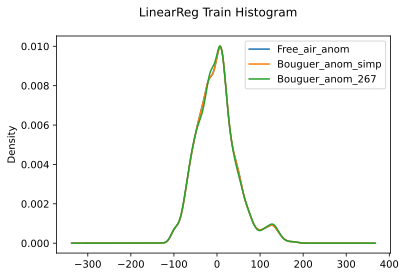


DecisionTree:
r2_train:   0.9999868093566158
mse_train: 0.06089174345771973
-------------------------------
Corr by Columns:


Free_air_anom        0.999996
Bouguer_anom_simp    0.999993
Bouguer_anom_267     0.999991
dtype: float64

-------------------------------

max diff:
Free_air_anom        6.277778
Bouguer_anom_simp    5.888889
Bouguer_anom_267     5.833333
dtype: float64


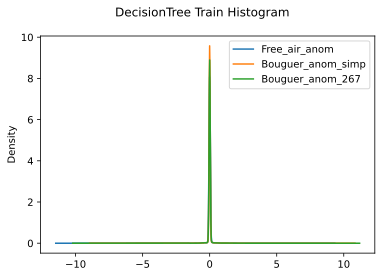


SVR:
r2_train:   0.2941619751099582
mse_train: 3187.789398700184
-------------------------------
Corr by Columns:


Free_air_anom        0.763691
Bouguer_anom_simp    0.443410
Bouguer_anom_267     0.326660
dtype: float64

-------------------------------

max diff:
Free_air_anom        193.464875
Bouguer_anom_simp    197.913924
Bouguer_anom_267     193.301421
dtype: float64


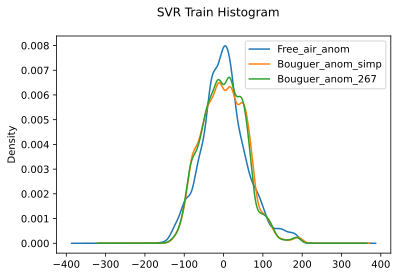


AdaBoostTree:
r2_train:   0.9998953626569373
mse_train: 0.4751808664163571
-------------------------------
Corr by Columns:


Free_air_anom        0.999968
Bouguer_anom_simp    0.999945
Bouguer_anom_267     0.999930
dtype: float64

-------------------------------

max diff:
Free_air_anom        4.57
Bouguer_anom_simp    4.24
Bouguer_anom_267     4.21
dtype: float64


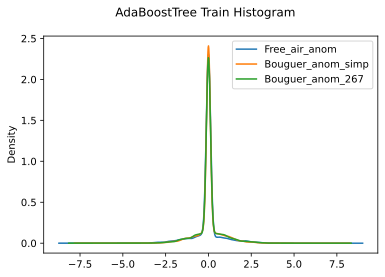


RandomForest:
r2_train:   0.9969333861136169
mse_train: 14.348585913560994
-------------------------------
Corr by Columns:


Free_air_anom        0.998943
Bouguer_anom_simp    0.998337
Bouguer_anom_267     0.998178
dtype: float64

-------------------------------

max diff:
Free_air_anom        59.132267
Bouguer_anom_simp    65.159090
Bouguer_anom_267     60.956752
dtype: float64


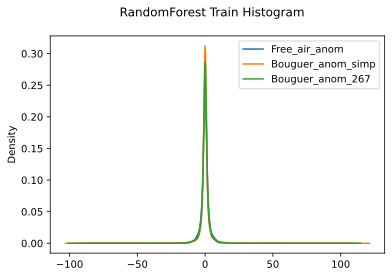

CPU times: user 8.7 s, sys: 153 ms, total: 8.85 s
Wall time: 11.9 s


In [9]:
%%time
print('\033[1m'+'Predict Train Stats')
for name, regr in regr_dict.items():
  print('\n\033[1m'+name+':'+'\033[0m')
  Y_pred_train = pd.DataFrame(
      regr.predict(X_train),
      columns=Y_train.columns,
      index=Y_train.index
      )
  r2_train = r2_score(Y_train, Y_pred_train)
  mse_train = mean_squared_error(Y_train, Y_pred_train)
  print('r2_train:  ', r2_train)
  print('mse_train:', mse_train)
  print('-------------------------------')
  print('\033[1m'+'Corr by Columns:'+'\033[0m')
  display(Y_train.corrwith(Y_pred_train))
  print('-------------------------------')
  diff=Y_train-Y_pred_train
  print('\n\033[1m'+'max diff:'+'\033[0m')
  print(abs(diff).max())
  diff.plot.kde()
  plt.yscale('linear')#'linear', 'log'
  plt.suptitle(name+' Train Histogram')
  diff.to_csv(name+'_diff_train.csv')
  plt.savefig(
      name+'_diff_train_hist.pdf',
      bbox_inches='tight'
      )
  plt.show()

Predict Train Stats

LinearReg:
r2_test:   0.4857450854806273
mse_test: 2254.8999170533853
-------------------------------
Corr by Columns:


Free_air_anom        0.853380
Bouguer_anom_simp    0.639993
Bouguer_anom_267     0.565919
dtype: float64

-------------------------------

max diff:
Free_air_anom        178.854030
Bouguer_anom_simp    178.859338
Bouguer_anom_267     176.153179
dtype: float64


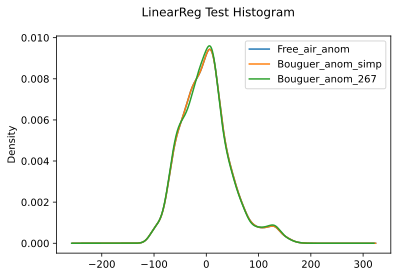


DecisionTree:
r2_test:   0.9562505284561169
mse_test: 194.7858221595654
-------------------------------
Corr by Columns:


Free_air_anom        0.987516
Bouguer_anom_simp    0.975646
Bouguer_anom_267     0.971482
dtype: float64

-------------------------------

max diff:
Free_air_anom        175.40
Bouguer_anom_simp    176.20
Bouguer_anom_267     169.28
dtype: float64


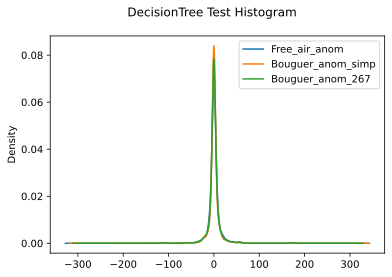


SVR:
r2_test:   0.2854114648792652
mse_test: 3208.0905160062866
-------------------------------
Corr by Columns:


Free_air_anom        0.759255
Bouguer_anom_simp    0.433607
Bouguer_anom_267     0.313352
dtype: float64

-------------------------------

max diff:
Free_air_anom        218.638043
Bouguer_anom_simp    194.187216
Bouguer_anom_267     189.692728
dtype: float64


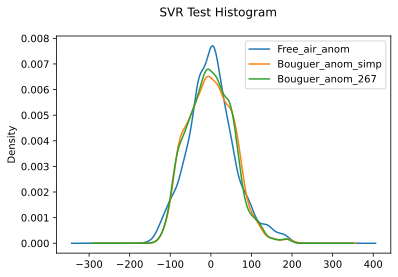


AdaBoostTree:
r2_test:   0.9810447246147365
mse_test: 85.23520315130337
-------------------------------
Corr by Columns:


Free_air_anom        0.994333
Bouguer_anom_simp    0.989082
Bouguer_anom_267     0.988049
dtype: float64

-------------------------------

max diff:
Free_air_anom        173.92
Bouguer_anom_simp    179.87
Bouguer_anom_267     187.48
dtype: float64


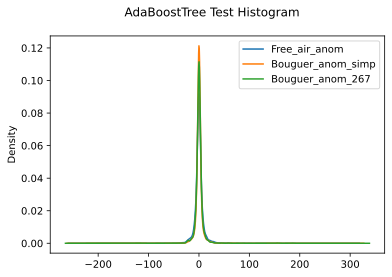


RandomForest:
r2_test:   0.9796142775666677
mse_test: 92.54963743057351
-------------------------------
Corr by Columns:


Free_air_anom        0.993591
Bouguer_anom_simp    0.988645
Bouguer_anom_267     0.987031
dtype: float64

-------------------------------

max diff:
Free_air_anom        161.893162
Bouguer_anom_simp    155.173366
Bouguer_anom_267     166.484619
dtype: float64


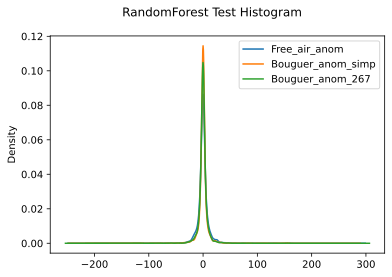

CPU times: user 5.85 s, sys: 116 ms, total: 5.97 s
Wall time: 8.81 s


In [10]:
%%time
print('\033[1m'+'Predict Train Stats')
for name, regr in regr_dict.items():
  print('\n\033[1m'+name+':'+'\033[0m')
  Y_pred_test = pd.DataFrame(
      regr.predict(X_test),
      columns=Y_test.columns,
      index=Y_test.index
      )
  r2_test = r2_score(Y_test, Y_pred_test)
  mse_test = mean_squared_error(Y_test, Y_pred_test)
  print('r2_test:  ', r2_test)
  print('mse_test:', mse_test)
  print('-------------------------------')
  print('\033[1m'+'Corr by Columns:'+'\033[0m')
  display(Y_test.corrwith(Y_pred_test))
  print('-------------------------------')
  diff=Y_test-Y_pred_test
  print('\n\033[1m'+'max diff:'+'\033[0m')
  print(abs(diff).max())
  diff.plot.kde()
  plt.yscale('linear')#'linear', 'log'
  plt.suptitle(name+' Test Histogram')
  diff.to_csv(name+'_diff_test.csv')
  plt.savefig(
      name+'_diff_test_hist.pdf',
      bbox_inches='tight'
      )
  plt.show()

# Neural

In [11]:
%%time

clear_session()
try:
  del nfit
  del nnet
except:
  pass

nnet = Sequential(name='Sequential')
nnet.add(Dense(5, name='hiden0',
               input_dim=3,
               kernel_initializer='random_normal',
               bias_initializer='zeros',
               activation='softplus')
)
nnet.add(Dense(3, name='hiden1', activation='softplus'))
nnet.add(Dense(5, name='hiden2', activation='softplus'))
nnet.add(Dense(3, name='hiden3', activation='softplus'))
nnet.add(Dense(5, name='hiden4', activation='softplus'))
nnet.add(Dense(3, name='Output'))

display(nnet.summary())
tqdm_callback = TqdmCallback(verbose=0)
time_callback = TimeHistory()
nnet.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mse']
    )
netfit = nnet.fit(
    X_train, Y_train,
    validation_data=(X_test, Y_test),
    epochs=2000,
    verbose=0,
    callbacks=[
      tqdm_callback,
      time_callback
      ]
    )

Model: "Sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hiden0 (Dense)               (None, 5)                 20        
_________________________________________________________________
hiden1 (Dense)               (None, 3)                 18        
_________________________________________________________________
hiden2 (Dense)               (None, 5)                 20        
_________________________________________________________________
hiden3 (Dense)               (None, 3)                 18        
_________________________________________________________________
hiden4 (Dense)               (None, 5)                 20        
_________________________________________________________________
Output (Dense)               (None, 3)                 18        
Total params: 114
Trainable params: 114
Non-trainable params: 0
__________________________________________________________

None


CPU times: user 11min 2s, sys: 40.8 s, total: 11min 42s
Wall time: 10min 14s


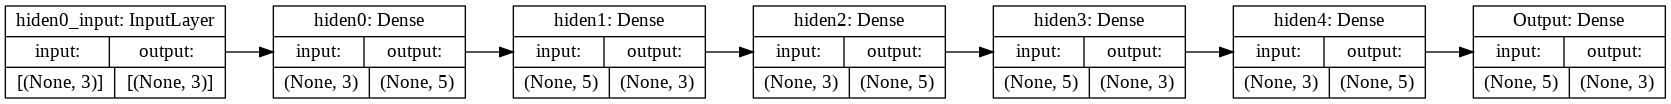

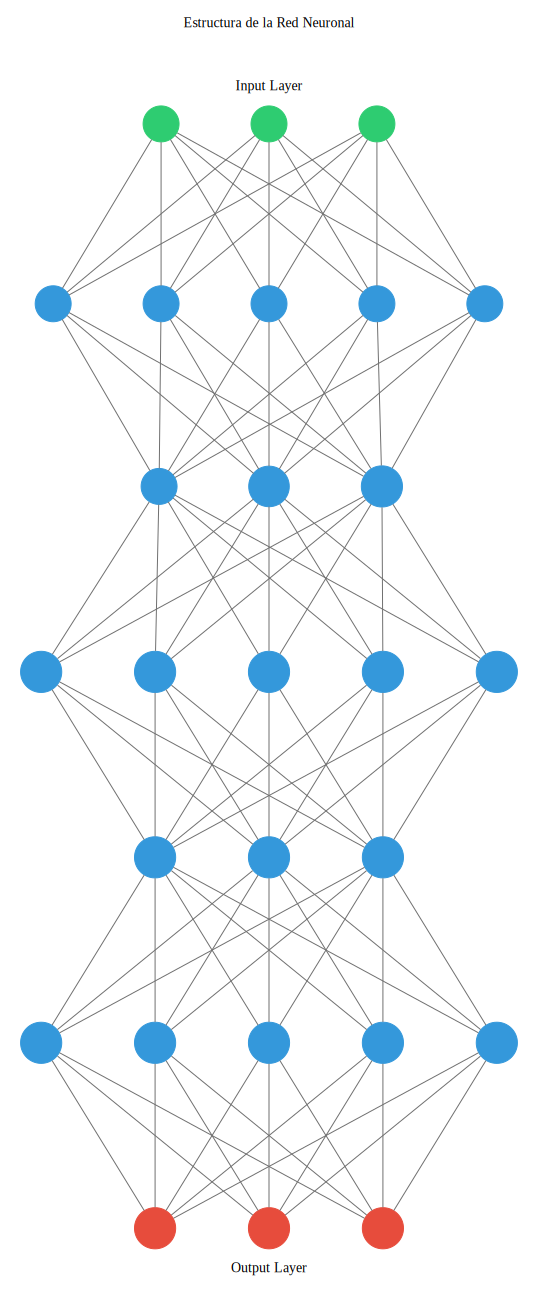

In [12]:
nnet_filename='neural_network'
display(plot_model(
    nnet,
    to_file=nnet_filename+'_diagram.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='LR'# LR, TB
    )
)
ann_viz(
    nnet,
    view=True,
    filename=nnet_filename,
    title='Estructura de la Red Neuronal'
    )
display(Source.from_file(nnet_filename))

,loss,mse,val_loss,val_mse,times
0,9392.099609,9392.099609,9381.283203,9381.283203,NaN
1,6455.091797,6455.091797,4283.154297,4283.154297,NaN
2,3755.868652,3755.868652,3714.921875,3714.921875,NaN
3,3629.319824,3629.319824,3700.117920,3700.117920,NaN
4,3615.791504,3615.791504,3690.277344,3690.277344,NaN
...,...,...,...,...,...
1995,1548.364380,1548.364380,1557.301636,1557.301636,290.467691
1996,1557.438721,1557.438721,1583.802612,1583.802612,282.294726
1997,1540.597046,1540.597046,1575.061523,1575.061523,276.191282
1998,1553.206177,1553.206177,1569.937500,1569.937500,276.798964


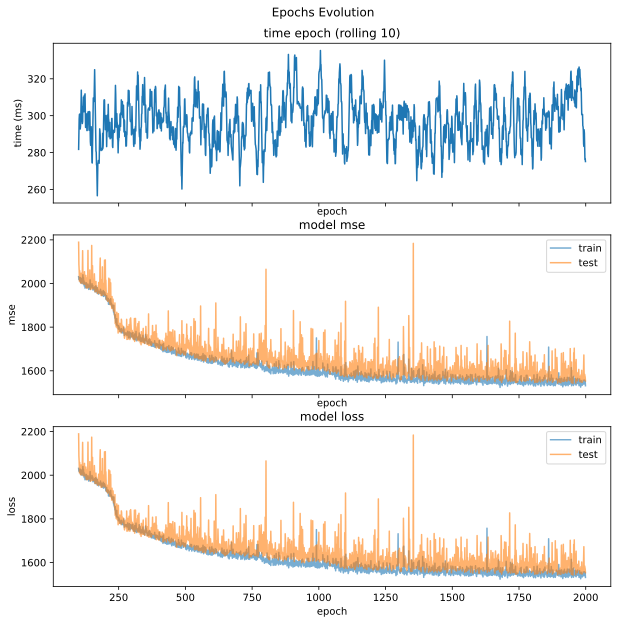

CPU times: user 1.95 s, sys: 46 ms, total: 2 s
Wall time: 2.6 s


In [13]:
%%time

!rm -f my_model.h5
model_filename = 'my_model.h5'
name='NeuralNetwork'
netfit.model.save(model_filename)
regr_dict[name] = load_model(model_filename)
regr = regr_dict[name]

dfhist = pd.DataFrame.from_dict(netfit.history)
nnet_times = 1000*pd.Series(time_callback.times)
dfhist = dfhist.assign(
    times=pd.Series(nnet_times).rolling(10).mean()
    )

dfhist.to_csv('dfhist.csv')
display(dfhist)

dfhist_new = dfhist[100:]
my_alpha = .6
fig, (ax0,ax1,ax2) = plt.subplots(3,1,
                              figsize=(10,10),
                              sharey=False, sharex=True,
                              gridspec_kw={'hspace': 2/10}
                              )
ax0.plot(dfhist_new['times'])
ax0.set_title('time epoch (rolling 10)')
ax0.set_ylabel('time (ms)')
ax0.set_xlabel('epoch')
ax1.plot(dfhist_new['mse'], alpha=my_alpha)
ax1.plot(dfhist_new['val_mse'], alpha=my_alpha)
ax1.set_title('model mse')
ax1.set_ylabel('mse')
ax1.set_xlabel('epoch')
ax1.legend(
    ['train', 'test'],
    loc='upper right'
    )
ax2.plot(dfhist_new['loss'], alpha=my_alpha)
ax2.plot(dfhist_new['val_loss'], alpha=my_alpha)
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(
    ['train', 'test'],
    loc='upper right'
    )
plt.suptitle('Epochs Evolution',y=.93)
plt.savefig(
    'epochs_evolution.pdf',
    bbox_inches='tight'
    )
plt.show()

r2_train:   0.6612124591482104
mse_train: 1502.6094085136976
-------------------------------
Corr by Columns:


Free_air_anom        0.903809
Bouguer_anom_simp    0.784372
Bouguer_anom_267     0.743241
dtype: float64

-------------------------------

max diff:
Free_air_anom        229.863556
Bouguer_anom_simp    215.520706
Bouguer_anom_267     214.447653
dtype: float64


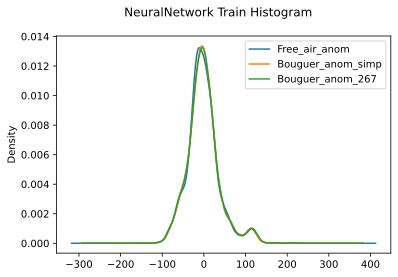

CPU times: user 1.73 s, sys: 42.2 ms, total: 1.78 s
Wall time: 2.2 s


In [14]:
%%time

Y_pred_train = pd.DataFrame(
    regr.predict(X_train),
    columns=Y_train.columns,
    index=Y_train.index
    )
r2_train = r2_score(Y_train, Y_pred_train)
mse_train = mean_squared_error(Y_train, Y_pred_train)
print('r2_train:  ', r2_train)
print('mse_train:', mse_train)
print('-------------------------------')
print('\033[1m'+'Corr by Columns:'+'\033[0m')
display(Y_train.corrwith(Y_pred_train))
print('-------------------------------')
diff=Y_train-Y_pred_train
print('\n\033[1m'+'max diff:'+'\033[0m')
print(abs(diff).max())
diff.plot.kde()
plt.yscale('linear')#'linear', 'log'
plt.suptitle(name+' Train Histogram')
diff.to_csv(name+'_diff_train.csv')
plt.savefig(
    name+'_diff_train_hist.pdf',
    bbox_inches='tight'
    )
plt.show()

r2_test:   0.6452606901348116
mse_test: 1553.3470449559234
-------------------------------
Corr by Columns:


Free_air_anom        0.902259
Bouguer_anom_simp    0.770893
Bouguer_anom_267     0.727711
dtype: float64

-------------------------------

max diff:
Free_air_anom        229.854578
Bouguer_anom_simp    215.532747
Bouguer_anom_267     213.451268
dtype: float64


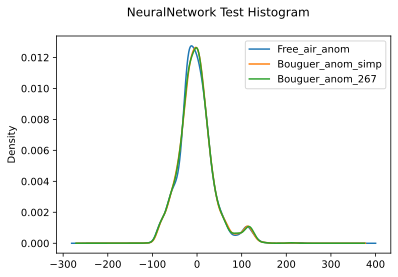

CPU times: user 991 ms, sys: 18 ms, total: 1.01 s
Wall time: 1.49 s


In [15]:
%%time

Y_pred_test = pd.DataFrame(
    regr.predict(X_test),
    columns=Y_test.columns,
    index=Y_test.index
    )
r2_test = r2_score(Y_test, Y_pred_test)
mse_test = mean_squared_error(Y_test, Y_pred_test)
print('r2_test:  ', r2_test)
print('mse_test:', mse_test)
print('-------------------------------')
print('\033[1m'+'Corr by Columns:'+'\033[0m')
display(Y_test.corrwith(Y_pred_test))
print('-------------------------------')
diff=Y_test-Y_pred_test
print('\n\033[1m'+'max diff:'+'\033[0m')
print(abs(diff).max())
diff.plot.kde()
plt.yscale('linear')#'linear', 'log'
plt.suptitle(name+' Test Histogram')
diff.to_csv(name+'_diff_test.csv')
plt.savefig(
    name+'_diff_test_hist.pdf',
    bbox_inches='tight'
    )
plt.show()

,Name,geometry
0,my_rectangle,"POLYGON ((-75.25000 6.85000, -75.25000 5.75000..."


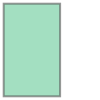

CPU times: user 32.1 ms, sys: 11.8 ms, total: 43.8 ms
Wall time: 1.11 s


In [16]:
%%time
my_rectangle_gpd = gpd.read_file('MGN2020/my_rectangle.shp')
display(my_rectangle_gpd)
my_rectangle = my_rectangle_gpd['geometry'].values[0]
display(my_rectangle)

In [17]:
%%time

bounds=np.reshape(my_rectangle.bounds,(2,2))
lon_min=bounds[0,0]
lat_min=bounds[0,1]
lon_max=bounds[1,0]
lat_max=bounds[1,1]

lons, lats, elevs = np.load(
    'elevs_data.npy',
    allow_pickle=True
    )
my_shape = np.shape(elevs)

srtmdf = pd.read_csv(
    'my_rectangle_srtm.csv',
    index_col=[0]
    )
display(srtmdf)

,latitude,longitude,SRTM
0,5.75,-75.92,1088.0
1,5.75,-75.91,1152.0
2,5.75,-75.90,1158.0
3,5.75,-75.89,1092.0
4,5.75,-75.88,1479.0
...,...,...,...
7654,6.85,-75.28,1680.0
7655,6.85,-75.27,1887.0
7656,6.85,-75.26,2006.0
7657,6.85,-75.25,2039.0


CPU times: user 29 ms, sys: 2.97 ms, total: 31.9 ms
Wall time: 815 ms


In [18]:
%%time

for name, regr in regr_dict.items():
  area_predict = pd.concat([
             srtmdf,
             pd.DataFrame(
                 regr_dict[name].predict(srtmdf),
                 columns=Y_columns
                 )], axis=1
            )
  area_predict.to_csv('area_predict_'+name+'.csv')
  print('Saved', 'area_predict_'+name+'.csv')

names=regr_dict.keys()
print(names)
area_predict_dict = {
    name: pd.read_csv(
        'area_predict_'+name+'.csv',
        index_col=[0])
        for name in names
        }

for name in names:
  print('\n\033[1m'+name+':\033[0m')
  display(area_predict_dict[name])

Saved area_predict_LinearReg.csv
Saved area_predict_DecisionTree.csv
Saved area_predict_SVR.csv
Saved area_predict_AdaBoostTree.csv
Saved area_predict_RandomForest.csv
Saved area_predict_NeuralNetwork.csv
dict_keys(['LinearReg', 'DecisionTree', 'SVR', 'AdaBoostTree', 'RandomForest', 'NeuralNetwork'])

LinearReg:


,latitude,longitude,SRTM,Free_air_anom,Bouguer_anom_simp,Bouguer_anom_267
0,5.75,-75.92,1088.0,44.143960,-77.603521,-67.235717
1,5.75,-75.91,1152.0,49.565962,-79.343139,-68.338271
2,5.75,-75.90,1158.0,50.027215,-79.553286,-68.488918
3,5.75,-75.89,1092.0,44.330295,-77.864782,-67.457886
4,5.75,-75.88,1479.0,77.378541,-88.121963,-73.861583
...,...,...,...,...,...,...
7654,6.85,-75.28,1680.0,102.692477,-85.299907,-68.858123
7655,6.85,-75.27,1887.0,120.345293,-90.810458,-72.307623
7656,6.85,-75.26,2006.0,130.471454,-94.000434,-74.312849
7657,6.85,-75.25,2039.0,133.242021,-94.922576,-74.906625



DecisionTree:


,latitude,longitude,SRTM,Free_air_anom,Bouguer_anom_simp,Bouguer_anom_267
0,5.75,-75.92,1088.0,34.60,-83.35,-75.55
1,5.75,-75.91,1152.0,76.93,-62.72,-48.25
2,5.75,-75.90,1158.0,76.93,-62.72,-48.25
3,5.75,-75.89,1092.0,34.60,-83.35,-75.55
4,5.75,-75.88,1479.0,91.02,-67.66,-48.61
...,...,...,...,...,...,...
7654,6.85,-75.28,1680.0,115.31,-76.26,-63.62
7655,6.85,-75.27,1887.0,151.12,-83.31,-60.98
7656,6.85,-75.26,2006.0,151.12,-83.31,-60.98
7657,6.85,-75.25,2039.0,151.12,-83.31,-60.98



SVR:


,latitude,longitude,SRTM,Free_air_anom,Bouguer_anom_simp,Bouguer_anom_267
0,5.75,-75.92,1088.0,2.353159,-73.101806,-65.552863
1,5.75,-75.91,1152.0,4.783889,-74.252356,-66.408866
2,5.75,-75.90,1158.0,5.023181,-74.364830,-66.492292
3,5.75,-75.89,1092.0,2.495885,-73.169039,-65.602783
4,5.75,-75.88,1479.0,21.216022,-81.825025,-71.976931
...,...,...,...,...,...,...
7654,6.85,-75.28,1680.0,35.009674,-87.954021,-76.411553
7655,6.85,-75.27,1887.0,52.721590,-95.743545,-82.016792
7656,6.85,-75.26,2006.0,64.627864,-100.917707,-85.718535
7657,6.85,-75.25,2039.0,68.163378,-102.445774,-86.808822



AdaBoostTree:


,latitude,longitude,SRTM,Free_air_anom,Bouguer_anom_simp,Bouguer_anom_267
0,5.75,-75.92,1088.0,53.23,-57.12,-51.06
1,5.75,-75.91,1152.0,61.83,-56.36,-47.56
2,5.75,-75.90,1158.0,61.83,-57.12,-47.79
3,5.75,-75.89,1092.0,54.87,-57.12,-51.46
4,5.75,-75.88,1479.0,93.62,-60.92,-48.16
...,...,...,...,...,...,...
7654,6.85,-75.28,1680.0,122.97,-82.84,-60.65
7655,6.85,-75.27,1887.0,131.15,-82.84,-60.65
7656,6.85,-75.26,2006.0,151.12,-82.84,-60.98
7657,6.85,-75.25,2039.0,151.12,-82.84,-60.98



RandomForest:


,latitude,longitude,SRTM,Free_air_anom,Bouguer_anom_simp,Bouguer_anom_267
0,5.75,-75.92,1088.0,57.362800,-60.136791,-52.309687
1,5.75,-75.91,1152.0,62.780400,-59.371048,-50.646796
2,5.75,-75.90,1158.0,63.257167,-59.065048,-50.934439
3,5.75,-75.89,1092.0,58.030333,-61.485144,-53.368558
4,5.75,-75.88,1479.0,100.875467,-60.383579,-49.294206
...,...,...,...,...,...,...
7654,6.85,-75.28,1680.0,118.107333,-77.352347,-61.979133
7655,6.85,-75.27,1887.0,141.166833,-77.706747,-59.984600
7656,6.85,-75.26,2006.0,159.850833,-77.705180,-59.705100
7657,6.85,-75.25,2039.0,159.281433,-77.697813,-59.526633



NeuralNetwork:


,latitude,longitude,SRTM,Free_air_anom,Bouguer_anom_simp,Bouguer_anom_267
0,5.75,-75.92,1088.0,39.518326,-85.343254,-74.875650
1,5.75,-75.91,1152.0,47.529957,-84.690125,-73.564900
2,5.75,-75.90,1158.0,48.285828,-84.622230,-73.435550
3,5.75,-75.89,1092.0,40.035965,-85.279724,-74.771600
4,5.75,-75.88,1479.0,88.272610,-81.523384,-67.038210
...,...,...,...,...,...,...
7654,6.85,-75.28,1680.0,95.823400,-95.541440,-78.917840
7655,6.85,-75.27,1887.0,116.876160,-97.606285,-78.866240
7656,6.85,-75.26,2006.0,128.961290,-98.807330,-78.850716
7657,6.85,-75.25,2039.0,132.300370,-99.148870,-78.855060


CPU times: user 3.88 s, sys: 84 ms, total: 3.96 s
Wall time: 5.96 s



LinearReg Heatmap_corr:
Saved LinearReg_corr.csv


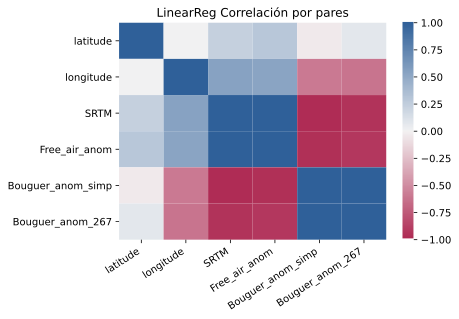


DecisionTree Heatmap_corr:
Saved DecisionTree_corr.csv


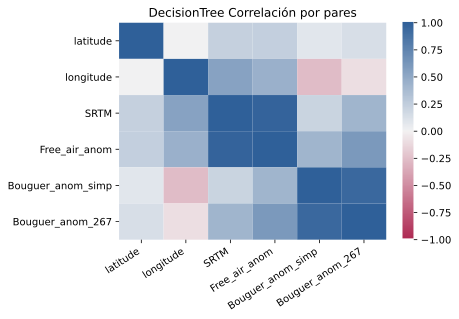


SVR Heatmap_corr:
Saved SVR_corr.csv


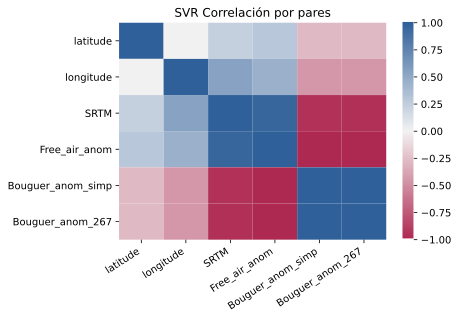


AdaBoostTree Heatmap_corr:
Saved AdaBoostTree_corr.csv


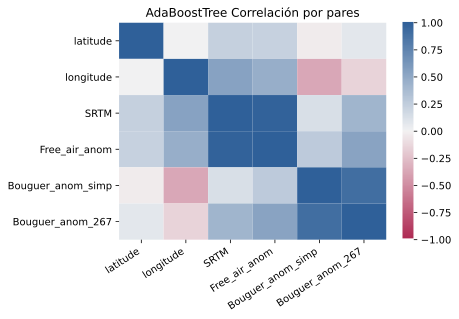


RandomForest Heatmap_corr:
Saved RandomForest_corr.csv


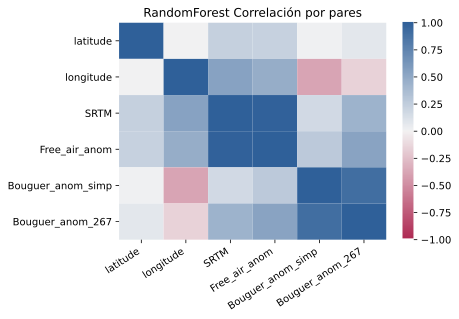


NeuralNetwork Heatmap_corr:
Saved NeuralNetwork_corr.csv


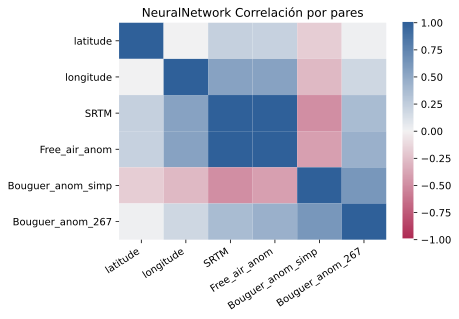

CPU times: user 3.63 s, sys: 764 ms, total: 4.4 s
Wall time: 8.41 s


In [19]:
%%time

for name, area_predict in area_predict_dict.items():
  print('\n\033[1m'+name+' Heatmap_corr:\033[0m')
  area_predict.corr().to_csv(name+'_corr.csv')
  print('Saved', name+'_corr.csv')
  heatmap=sns.heatmap(
      area_predict.corr(),
      vmin=-1,
      vmax=+1,
      cmap=sns.diverging_palette(
          0, 250,
          s=80, l=40,
          n=1000,
          as_cmap=True,
          center='light'
          )
      )
  heatmap.set_xticklabels(
      heatmap.get_xticklabels(),
      rotation=33,
      horizontalalignment='right'
      )
  plt.title(name+' Correlación por pares')
  plt.savefig(
      name+'_heatmap.pdf',
      bbox_inches='tight'
      )
  plt.show()

In [20]:
%%time

for name, area_predict in area_predict_dict.items():
  print('\n\033[1m'+name+' Pairplot:\033[0m')
  sns.pairplot(
      area_predict.sample(1000),
      kind='kde',
      corner=True,
      height=2
      ).fig.suptitle(
          name+' Pairplot',
          y=1.02
          )
  plt.savefig(
      name+'_pairplot.pdf',
      bbox_inches='tight'
      )
  plt.show()

Output hidden; open in https://colab.research.google.com to view.


LinearReg:


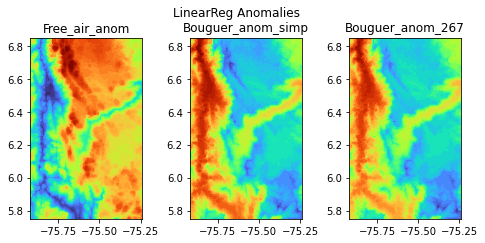


DecisionTree:


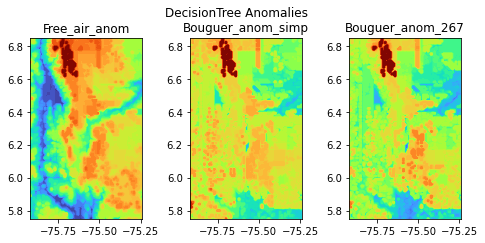


SVR:


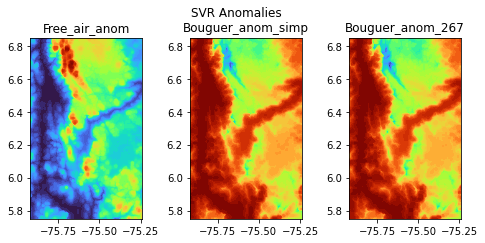


AdaBoostTree:


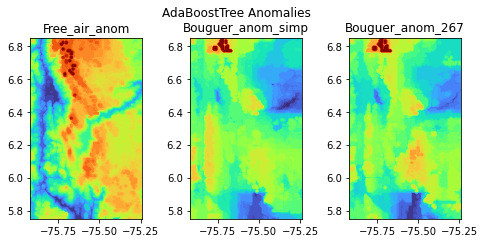


RandomForest:


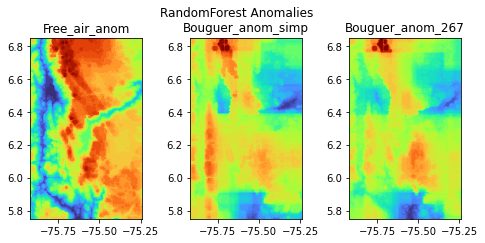


NeuralNetwork:


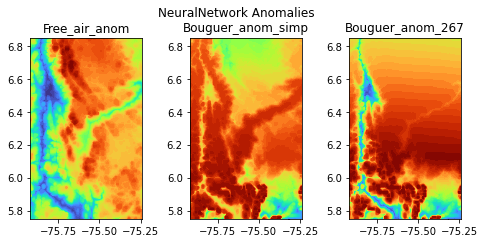

CPU times: user 5.15 s, sys: 67.6 ms, total: 5.21 s
Wall time: 5.25 s


In [21]:
%%time

set_matplotlib_formats('png')
for name, area_predict in area_predict_dict.items():
  print('\n\033[1m'+name+':\033[0m')
  set_matplotlib_formats('png')
  fig, axs = plt.subplots(1,3,
                          figsize=(10,10/3),
                          sharey=False,
                          gridspec_kw={'wspace': -1/3}
                          )
  for i, column  in enumerate(Y_columns):
    cf=axs[i].contourf(
        lons, lats,
        np.reshape(area_predict[column].to_numpy(),my_shape),
        levels=50,
        cmap='turbo'
        )
    # Rasterize the contour collections
    # https://stackoverflow.com/a/32911755
    for c in cf.collections:
      c.set_edgecolor('face')
    axs[i].set_aspect(1)
    axs[i].set_title(column)
  plt.suptitle(name+' Anomalies',y=1.01)
  plt.show()
  set_matplotlib_formats('pdf', 'svg')

In [22]:
for name in names:
  print('\n\033[1m'+name+':\033[0m')
  print('\n\033[1m'+'Max'+':\033[0m')
  display(area_predict_dict[name][Y_columns].max())
  print('\n\033[1m'+'Mmin'+':\033[0m')
  display(area_predict_dict[name][Y_columns].min())
  print('-------------------------------')


LinearReg:

Max:


Free_air_anom        239.691365
Bouguer_anom_simp    -48.385917
Bouguer_anom_267     -44.933814
dtype: float64


Mmin:


Free_air_anom         -6.423360
Bouguer_anom_simp   -129.120073
Bouguer_anom_267    -100.407178
dtype: float64

-------------------------------

DecisionTree:

Max:


Free_air_anom        336.76
Bouguer_anom_simp      1.84
Bouguer_anom_267      30.78
dtype: float64


Mmin:


Free_air_anom        -43.67
Bouguer_anom_simp   -146.60
Bouguer_anom_267    -121.20
dtype: float64

-------------------------------

SVR:

Max:


Free_air_anom        290.399212
Bouguer_anom_simp    -66.047704
Bouguer_anom_267     -60.172340
dtype: float64


Mmin:


Free_air_anom        -11.678228
Bouguer_anom_simp   -195.311697
Bouguer_anom_267    -151.943606
dtype: float64

-------------------------------

AdaBoostTree:

Max:


Free_air_anom        336.76
Bouguer_anom_simp      1.84
Bouguer_anom_267      30.78
dtype: float64


Mmin:


Free_air_anom        -33.7
Bouguer_anom_simp   -114.2
Bouguer_anom_267    -102.2
dtype: float64

-------------------------------

RandomForest:

Max:


Free_air_anom        290.199933
Bouguer_anom_simp    -24.370433
Bouguer_anom_267       9.174133
dtype: float64


Mmin:


Free_air_anom        -30.136783
Bouguer_anom_simp   -113.541227
Bouguer_anom_267    -102.608104
dtype: float64

-------------------------------

NeuralNetwork:

Max:


Free_air_anom        261.87810
Bouguer_anom_simp    -80.63878
Bouguer_anom_267     -64.80359
dtype: float64


Mmin:


Free_air_anom        -42.776240
Bouguer_anom_simp   -126.625080
Bouguer_anom_267     -98.029236
dtype: float64

-------------------------------


In [23]:
%%time

vmindic = {column: min([area_predict_dict[name][column].min()
            for name in names])
              for column in Y_columns
              }
vmaxdic = {column: max([area_predict_dict[name][column].max() 
            for name in names])
              for column in Y_columns
              }

print('vmindic:', vmindic)
print('vmaxdic:', vmaxdic)

vmindic: {'Free_air_anom': -43.67, 'Bouguer_anom_simp': -195.3116967974277, 'Bouguer_anom_267': -151.94360608370138}
vmaxdic: {'Free_air_anom': 336.76, 'Bouguer_anom_simp': 1.84, 'Bouguer_anom_267': 30.78}
CPU times: user 5.59 ms, sys: 0 ns, total: 5.59 ms
Wall time: 5.84 ms



LinearReg:


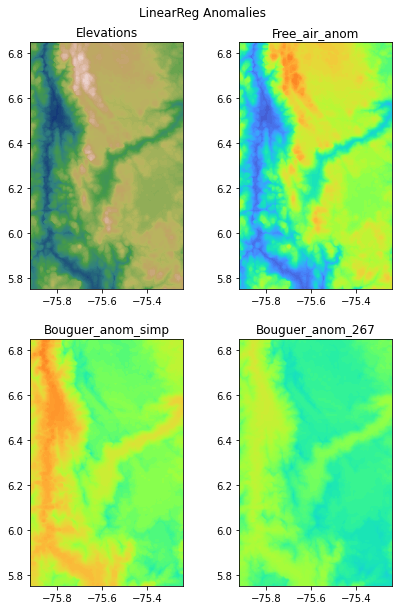


DecisionTree:


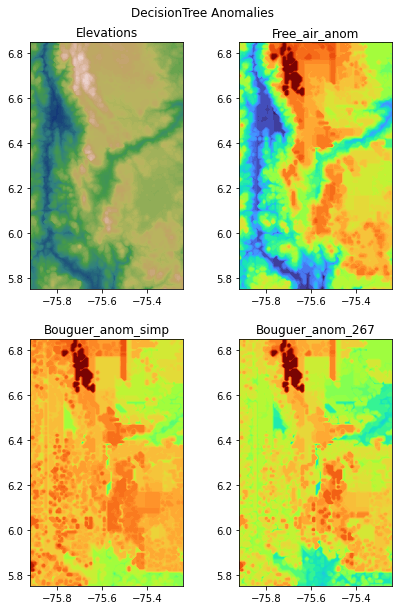


SVR:


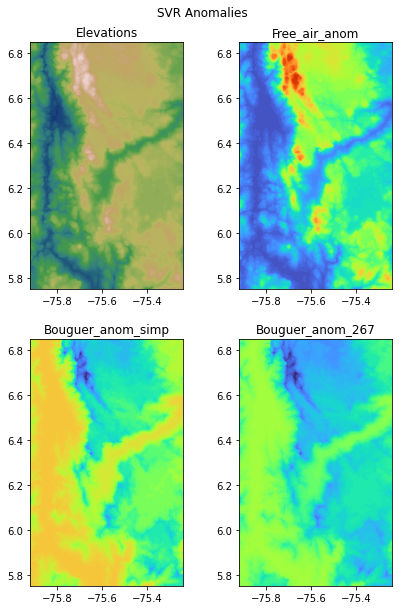


AdaBoostTree:


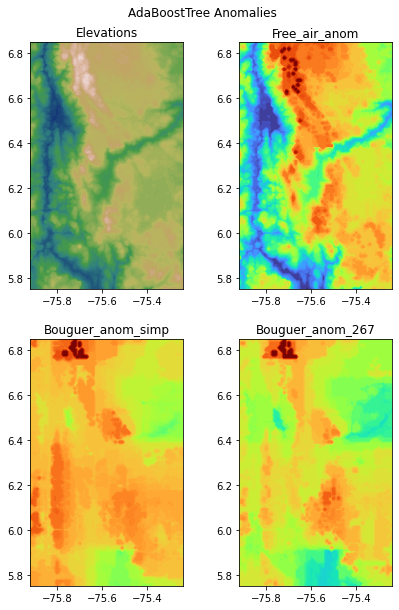


RandomForest:


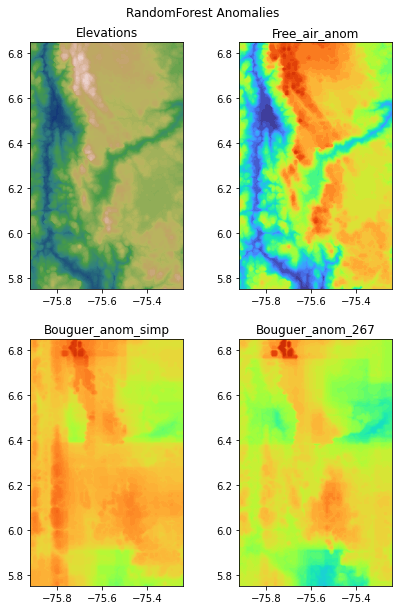


NeuralNetwork:


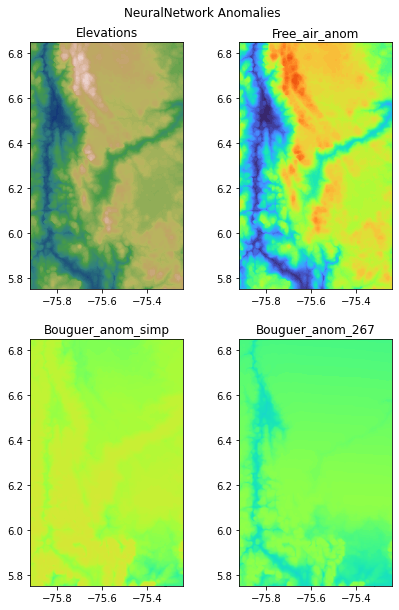

CPU times: user 6.97 s, sys: 66.3 ms, total: 7.04 s
Wall time: 7.04 s


In [24]:
%%time

set_matplotlib_formats('png')
for name, area_predict in area_predict_dict.items():
  print('\n\033[1m'+name+':\033[0m')
  fig, axs = plt.subplots(2,2,
                          figsize=(10,10),
                          sharey=False, sharex=False,
                          gridspec_kw={'wspace': -2/5,
                                       'hspace': 2/10}
                          )
  cf=axs[0,0].contourf(
      lons, lats, elevs,
      levels=50,
      vmin=0,
      vmax=3500,
      cmap='gist_earth'
      )
  # Rasterize the contour collections
  # https://stackoverflow.com/a/32911755
  for c in cf.collections:
    c.set_edgecolor('face')
  axs[0,0].set_aspect(1)
  axs[0,0].set_title('Elevations')
  axdic = {Y_columns[0]: axs[0,1],
           Y_columns[1]: axs[1,0],
           Y_columns[2]: axs[1,1]
           }
  for column  in Y_columns:
    ax=axdic[column]
    cf=ax.contourf(
        lons, lats,
        np.reshape(area_predict[column].to_numpy(),my_shape),
        levels=50,
        vmin=vmindic[column],
        vmax=vmaxdic[column],
        cmap='turbo'
        )
    # Rasterize the contour collections
    # https://stackoverflow.com/a/32911755
    for c in cf.collections:
      c.set_edgecolor('face')
    ax.set_aspect(1)
    ax.set_title(column)
  plt.suptitle(name+' Anomalies',y=.93)
  plt.show()
set_matplotlib_formats('pdf', 'svg')